## Modèle de Heston

Le modèle de Heston est un modèle stochastique à volatilité non constante utilisé pour la modélisation de l'évolution du prix d’un actif. Pour chaque actif i, il est défini par le système d'équations différentielles stochastiques suivant :

\[
\begin{cases}
dS_t^{(i)} = \mu S_t^{(i)}\, dt + \sqrt{v_t^{(i)}}\, S_t^{(i)}\, dB_t^{(i)}   -->  dln(S_t^{(i)}) = (\mu - 0.5.v_t^{(i)})dt + \sqrt{v_t^{(i)}}\, dB_t^{(i)}\\
dv_t^{(i)} = \kappa^{(i)}(\theta^{(i)} - v_t^{(i)})\, dt + \sigma^{(i)} \sqrt{v_t^{(i)}}\, dW_t^{(i)} \\
\end{cases}
\]

avec une corrélation entre les deux mouvements browniens donnée par :

\[
\begin{cases}
dB_t^{(i)} dW_t^{(i)} = \rho^{(i)}\, dt \\
\end{cases}
\]

### Signification des paramètres :

- \( S_t \) : prix de l’actif à l’instant \( t \)
- \( v_t \) : variance instantanée (volatilité au carré)
- \( \mu \) : taux de rendement de l’actif
- \( \kappa \) : vitesse de retour à la moyenne
- \( \theta \) : niveau de variance de long terme
- \( \sigma \) : volatilité de la variance (aussi appelée "vol of vol")
- \( \rho \) : corrélation entre les deux bruits browniens



In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cvxpy as cp
#import warnings
from copy import deepcopy

from scipy.optimize import minimize
import matplotlib.pyplot as plt

from Classes.marketmodel_interface import MarketModel
from Classes.simulation_interface import Simulation

### Import data for calibration
CAC40

In [2]:
# Create dictionary to store dataFrames for the 40 CAC40 companies
Data10y_dic = {}

# Get list of files containing 'Data' in the "Data/CAC40 daily 10y"
directory = "Data/CAC40 daily 10y"
files = [f for f in os.listdir(directory) if 'Data' in f]
# Process each file
for file in files:
    # Get company name (first word before '_')
    company = file.split('_')[0]
    
    # Read the file with tab separator
    df = pd.read_csv(os.path.join(directory, file), sep='\t')
    
    # Convert first column to datetime and set as index
    df.index = pd.to_datetime(df['date'], format='%d/%m/%Y %H:%M')

    df = df.drop('date', axis=1)  # Remove the original date column
    df = df.dropna(axis=1, how='all') # Drop columns with all NaN values
    
    # Store in dictionary
    Data10y_dic[company] = df

# Create a DataFrame with all the closing prices
dfs = [df['clot'] for df in Data10y_dic.values()]
histo_CAC40 = pd.concat(dfs, axis=1, keys=Data10y_dic.keys())
histo_CAC40 = histo_CAC40.sort_index()

data = histo_CAC40.dropna()
nb_stocks = 40
allocations_EW = np.ones(nb_stocks) / nb_stocks
# Import the weights data of CAC40
CAC40_weights_df = pd.read_csv('Data/InfoCAC40.csv', sep=';').set_index('Company')
# Convert string values to float
CAC40_weights = CAC40_weights_df.iloc[0, :].str.replace(',', '.').astype(float).values

In [3]:
Data10y_dic['SCHNEIDERELECTRIC']

,ouv,haut,bas,clot,vol,devise
date,,,,,,
2015-03-09,71.34,71.34,70.83,70.86,1304793,EUR
2015-03-10,70.84,71.00,69.76,70.18,1554765,EUR
2015-03-11,70.69,72.36,70.48,72.35,2241489,EUR
2015-03-12,72.72,72.85,71.72,71.83,1594580,EUR
2015-03-13,72.24,73.51,72.02,73.51,2353288,EUR
...,...,...,...,...,...,...
2025-03-03,233.20,235.75,227.65,229.65,1176017,EUR
2025-03-04,224.30,226.55,213.80,218.80,1944198,EUR
2025-03-05,226.45,229.90,224.25,226.15,1523898,EUR


In [4]:
logreturn_data = np.log(data / data.shift() )
logreturn_data.iloc[0,:] = 0.0

begin_date_data = str(data.index[0])[:10]
end_date_data = str(data.index[-1])[:10]

### Heston model
Simulation

In [5]:
def simulation_heston(V0, Theta, rho, kappa, khi, T, S0, r, nb_steps=252, nb_paths=10000):
    """
    Simulate Heston model paths
    
    Parameters:
    -----------
    V0: float
        Initial variance
    Theta: float
        Long-run average variance
    rho: float
        Correlation between stock and variance processes
    kappa: float
        Mean reversion speed
    khi: float
        Volatility of variance
    T: float
        Time horizon in years
    S0: float
        Initial stock price
    nb_steps: int
        Number of time steps
    nb_paths: int
        Number of simulation paths
    
    Returns:
    --------
    tuple: (stock_paths, variance_paths)
        Arrays containing simulated paths for stock price and variance
    """
    
    dt = T/nb_steps
    
    # Initialize arrays
    stock_paths = np.zeros((nb_paths, nb_steps+1))
    variance_paths = np.zeros((nb_paths, nb_steps+1))
    
    # Set initial values
    stock_paths[:, 0] = S0
    variance_paths[:, 0] = V0
    
    # Generate correlated random numbers
    Z1 = np.random.standard_normal((nb_paths, nb_steps))
    Z2 = rho * Z1 + np.sqrt(1 - rho**2) * np.random.standard_normal((nb_paths, nb_steps))
    
    # Simulate paths
    for t in range(nb_steps):
        # Ensure variance stays positive
        variance_paths[:, t] = np.maximum(variance_paths[:, t], 0)
        # Update variance
        variance_paths[:, t+1] = variance_paths[:, t] + kappa * (Theta - variance_paths[:, t]) * dt + khi * np.sqrt(variance_paths[:, t] * dt) * Z1[:, t]
        # Update stock price
        stock_paths[:, t+1] = stock_paths[:, t] * np.exp((r - 0.5 * variance_paths[:, t]) * dt + np.sqrt(variance_paths[:, t] * dt) * Z2[:, t])
    
    return stock_paths, variance_paths

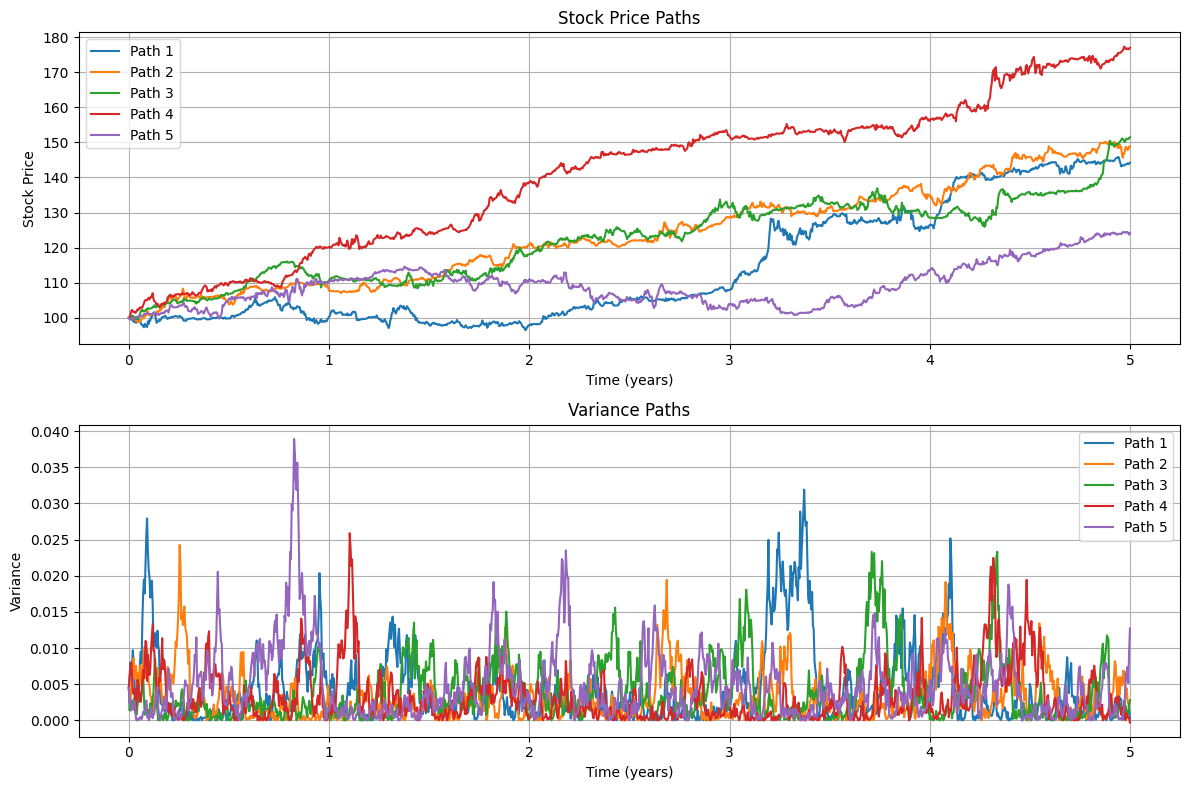

In [6]:
# Simulation parameters
T = 5.0  # 1 year
nb_paths = 5  # number of paths to display
nb_steps = 252*5  # trading days in a year
Stock_price_0 = 100  # initial stock price

# Heston model parameters
V0 = 0.0045 #initial variance
Theta = 0.0041 #the long variance, or long-run average variance of the price
rho = 0.1 #the correlation of the two BROWN processes, the stock price and the variance process
kappa = 14.6431 # the rate at which νt reverts to θ
khi = 40.13/100 #the volatility of the volatility, or 'vol of vol'
mu = 0.07 #the drift of the stock price process

# Run simulation
stock_paths, variance_paths = simulation_heston(V0, Theta, rho, kappa, khi, T, Stock_price_0, mu, nb_steps, nb_paths)

# Create time array
time = np.linspace(0, T, nb_steps + 1)

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# Plot stock price paths
for i in range(nb_paths):
    ax1.plot(time, stock_paths[i], label=f'Path {i+1}')
ax1.set_title('Stock Price Paths')
ax1.set_xlabel('Time (years)')
ax1.set_ylabel('Stock Price')
ax1.legend()
ax1.grid(True)

# Plot variance paths
for i in range(nb_paths):
    ax2.plot(time, variance_paths[i], label=f'Path {i+1}')
ax2.set_title('Variance Paths')
ax2.set_xlabel('Time (years)')
ax2.set_ylabel('Variance')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

#### Calibration with historical data
1 stock

In [7]:
Data10y_dic.keys()

dict_keys(['ACCOR', 'AIRBUS', 'AIRLIQUIDE', 'ARCELORMITTAL', 'AXA', 'BNPPARIBAS', 'BOUYGUES', 'BUREAUVERITAS', 'CAPGEMINI', 'CARREFOUR', 'CREDITAGRICOLESA', 'DANONE', 'DASSAULTSYSTEMES', 'EDENRED', 'ENGIE', 'ESSILORLUXOTTICA', 'EUROFINSSCIENTIFIC', 'HERMESINTL', 'KERING', 'LEGRAND', 'LOREAL', 'LVMH', 'MICHELIN', 'ORANGE', 'PERNODRICARD', 'PUBLICISGROUPE', 'RENAULT', 'SAFRAN', 'SAINTGOBAIN', 'SANOFI', 'SCHNEIDERELECTRIC', 'SOCIETEGENERALE', 'STELLANTIS', 'STMICROELECTRONICS', 'TELEPERFORMANCE', 'THALES', 'TOTALENERGIES', 'UNIBAILRODAMCOWESTFIELD', 'VEOLIA', 'VINCI'])

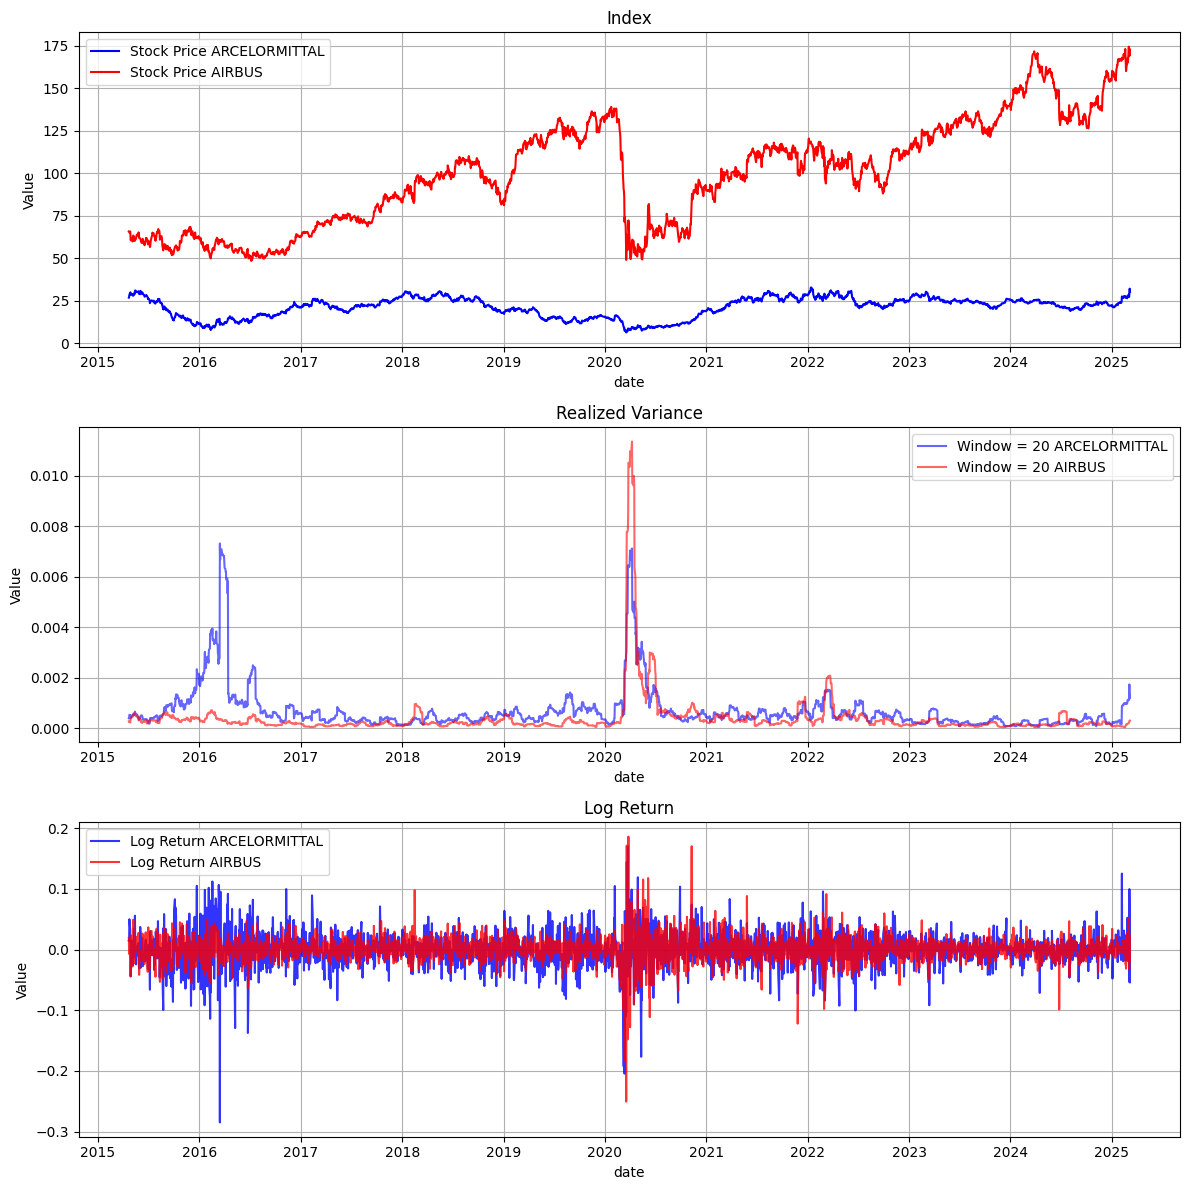

In [8]:
company1, company2 = 'ARCELORMITTAL', 'AIRBUS'

df = Data10y_dic[company1].copy()
df2 = Data10y_dic[company2].copy()

df.reset_index(inplace=True)
df['LogReturn'] = np.log(df['clot'] / df['clot'].shift(1))
df['Delta days'] = df['date'].diff().dt.total_seconds() / 3600 / 24
df['LogReturn daily'] = df['LogReturn'] / df['Delta days']
df.dropna(inplace=True)

df2.reset_index(inplace=True)
df2['LogReturn'] = np.log(df2['clot'] / df2['clot'].shift(1))
df2['Delta days'] = df2['date'].diff().dt.total_seconds() / 3600 / 24
df2['LogReturn daily'] = df2['LogReturn'] / df2['Delta days']
df2.dropna(inplace=True)

# === 2. Estimer la volatilité instantanée (rolling window) ===
window1 = 10
window2 = 20  # jours
window3 = 30

df['RealizedVar '+str(window1)] = df['LogReturn'].rolling(window1).var()
df['RealizedVar daily ' + str(window1)] = df['LogReturn daily'].rolling(window1).var()
df['RealizedVar '+str(window2)] = df['LogReturn'].rolling(window2).var()
df['RealizedVar daily '+str(window2)] = df['LogReturn daily'].rolling(window2).var()
df['RealizedVar '+str(window3)] = df['LogReturn'].rolling(window3).var()
df['RealizedVar daily '+str(window3)] = df['LogReturn daily'].rolling(window3).var()

df2['RealizedVar '+str(window1)] = df2['LogReturn'].rolling(window1).var()
df2['RealizedVar daily ' + str(window1)] = df2['LogReturn daily'].rolling(window1).var()
df2['RealizedVar '+str(window2)] = df2['LogReturn'].rolling(window2).var()
df2['RealizedVar daily '+str(window2)] = df2['LogReturn daily'].rolling(window2).var()
df2['RealizedVar '+str(window3)] = df2['LogReturn'].rolling(window3).var()
df2['RealizedVar daily '+str(window3)] = df2['LogReturn daily'].rolling(window3).var()

df.dropna(inplace=True)
df2.dropna(inplace=True)

# === Plot index and var on two graph ===
# Create figure with two subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 12))
# Plot index value
ax1.plot(df['date'], df['clot'], label='Stock Price '+company1, color='blue')
ax1.plot(df2['date'], df2['clot'], label='Stock Price '+company2, color='red')
ax1.set_title('Index')
ax1.set_xlabel('date')
ax1.set_ylabel('Value')
ax1.legend()
ax1.grid(True)
# Plot variance value
#ax2.plot(df['date'], df['RealizedVar daily ' + str(window1)], label='Window = ' +str(window1) + ' ' + company1, color='Blue', alpha=0.8)
#ax2.plot(df['date'], df2['RealizedVar daily ' + str(window1)], label='Window = ' +str(window1) + ' ' + company2, color='Red', alpha=0.8)
ax2.plot(df['date'], df['RealizedVar daily ' + str(window2)], label='Window = ' +str(window2) + ' ' + company1, color='Blue', alpha=0.6)
ax2.plot(df['date'], df2['RealizedVar daily ' + str(window2)], label='Window = ' +str(window2) + ' ' + company2, color='Red', alpha=0.6)
#ax2.plot(df['date'], df['RealizedVar daily ' + str(window3)], label='Window = ' +str(window3) + ' ' + company1, color='blue', alpha=0.4)
#ax2.plot(df['date'], df2['RealizedVar daily ' + str(window3)], label='Window = ' +str(window3) + ' ' + company2, color='red', alpha=0.4)
ax2.set_title('Realized Variance')
ax2.set_xlabel('date')
ax2.set_ylabel('Value')
ax2.legend()
ax2.grid(True)
# Plot log return
ax3.plot(df['date'], df['LogReturn'], label='Log Return ' + company1, color='blue', alpha=0.8)
ax3.plot(df2['date'], df2['LogReturn'], label='Log Return ' + company2, color='red', alpha=0.8)
ax3.set_title('Log Return')
ax3.set_xlabel('date')
ax3.set_ylabel('Value')
ax3.legend()
ax3.grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


### Calibration sur 1 stock

In [9]:
# === 3. Fonction de vraisemblance du modèle de Heston ===
def heston_log_likelihood(params, returns, var, mu):
    kappa, theta, sigma, rho = params
    dt = 1/365.25  # pas de temps (1 jour)
    n = len(returns)
    loglik = 0

    for t in range(1, n):
        v_prev = var[t - 1] * (365.25)**0.5 
        v_curr = var[t] * (365.25)**0.5  # volatilité annuelle

        # Moyennes conditionnelles
        mu_r = mu*dt # drift négligé
        mu_v = v_prev + kappa * (theta - v_prev) * dt

        # Variances conditionnelles
        var_r = v_prev * dt
        var_v = sigma**2 * v_prev * dt
        cov_rv = rho * sigma * v_prev * dt  # covariance entre r_t et v_t

        # Densité gaussienne bivariée (rendement, variance)
        x = np.array([returns[t] - mu_r, v_curr - mu_v])
        cov_matrix = np.array([[var_r, cov_rv],
                               [cov_rv, var_v]])
        
        try:
            det = np.linalg.det(cov_matrix)
            inv = np.linalg.inv(cov_matrix)
            ll = -0.5 * np.log(2 * np.pi)**2 - 0.5 * np.log(det) - 0.5 * x.T @ inv @ x
            loglik += ll
        except np.linalg.LinAlgError:
            return np.inf  # éviter les cas non-inversibles

    return -loglik

# === 4. Calibration par MLE ===
returns = df['LogReturn daily'].values
mu = df['LogReturn'].mean() * 365.25  # annualized mean return
var1 = df['RealizedVar daily ' + str(window1)].values
var2 = df['RealizedVar daily ' + str(window2)].values
var3 = df['RealizedVar daily ' + str(window3)].values

# initial guess
initial_guess = [1.0, 0.02, 0.5, -0.01]  # [kappa, theta, sigma, rho]
bounds = [(0.01, 70.0),  # kappa
          (1e-6, 0.5),   # theta
          (1e-6, 1.5),   # sigma
          (-0.3, 0.3)]  # rho

# Optimisation
res1 = minimize(heston_log_likelihood,
               initial_guess,
               args=(returns, var1, mu),
               bounds=bounds,
               method='L-BFGS-B')
# Affichage des résultats
print("=== Résultats de la calibration ===")
kappa1, theta1, sigma1, rho1 = res1.x
print(f"Paramètres estimés with window=" + str(window1))
print(f"  μ  = {mu:.4f}")
print(f"  κ  = {kappa1:.4f}")
print(f"  θ  = {theta1:.4f}")
print(f"  σ  = {sigma1:.4f}")
print(f"  ρ  = {rho1:.4f}")

res2 = minimize(heston_log_likelihood,
               initial_guess,
               args=(returns, var2, mu),
               bounds=bounds,
               method='L-BFGS-B')

# Affichage des résultats
kappa2, theta2, sigma2, rho2 = res2.x
print(f"Paramètres estimés with window=" + str(window2))
print(f"  μ  = {mu:.4f}")
print(f"  κ  = {kappa2:.4f}")
print(f"  θ  = {theta2:.4f}")
print(f"  σ  = {sigma2:.4f}")
print(f"  ρ  = {rho2:.4f}")


res3 = minimize(heston_log_likelihood,
               initial_guess,
                args=(returns, var3, mu),
                bounds=bounds,
                method='L-BFGS-B')
# Affichage des résultat
kappa3, theta3, sigma3, rho3 = res3.x
print(f"Paramètres estimés with window=" + str(window3))
print(f"  μ  = {mu:.4f}")
print(f"  κ  = {kappa3:.4f}")
print(f"  θ  = {theta3:.4f}")
print(f"  σ  = {sigma3:.4f}")
print(f"  ρ  = {rho3:.4f}")


=== Résultats de la calibration ===
Paramètres estimés with window=10
  μ  = 0.0202
  κ  = 13.8264
  θ  = 0.0136
  σ  = 0.6877
  ρ  = -0.0049
Paramètres estimés with window=20
  μ  = 0.0202
  κ  = 5.3610
  θ  = 0.0136
  σ  = 0.3655
  ρ  = -0.0167
Paramètres estimés with window=30
  μ  = 0.0202
  κ  = 2.4826
  θ  = 0.0143
  σ  = 0.2334
  ρ  = -0.0079


#### Multi Calibration

In [10]:
window = 20  # days

logReturn_daily = np.log(data / data.shift(1))
logReturn_daily /= data.index.to_series().diff().dt.days.values.reshape(-1, 1)

#Compute the rolling variance using a window of 20 days for each stock
realized_var = logReturn_daily.rolling(window).var()
realized_var.dropna(inplace=True)

# initial guess
initial_guess = [1.0, 0.02, 0.5, -0.01]  # [kappa, theta, sigma, rho]
bounds = [(0.01, 20.0),  # kappa
          (1e-6, 0.9),   # theta
          (1e-6, 2),   # sigma
          (-0.3, 0.6)]  # rho

df_params = pd.DataFrame(index=['mu', 'kappa', 'theta', 'sigma', 'rho'], columns=data.columns)
df_params.index.name = 'Parameters'

for company in data.columns:
    returns = logReturn_daily.iloc[window:,:][company].values
    var = realized_var[company].values
    mu = returns.mean() * 365.25  # annualized mean return
    # Optimisation
    res = minimize(heston_log_likelihood,
                   initial_guess,
                   args=(returns, var, mu),
                   bounds=bounds,
                   method='L-BFGS-B')
    
    # Affichage des résultats
    kappa, theta, sigma, rho = res.x
    df_params[company] = [mu, kappa, theta, sigma, rho]

df_params

,ACCOR,AIRBUS,AIRLIQUIDE,ARCELORMITTAL,AXA,BNPPARIBAS,BOUYGUES,BUREAUVERITAS,CAPGEMINI,CARREFOUR,...,SCHNEIDERELECTRIC,SOCIETEGENERALE,STELLANTIS,STMICROELECTRONICS,TELEPERFORMANCE,THALES,TOTALENERGIES,UNIBAILRODAMCOWESTFIELD,VEOLIA,VINCI
Parameters,,,,,,,,,,,,,,,,,,,,,
mu,0.073088,0.112466,0.170027,0.008417,0.119623,0.084162,0.021860,0.086556,0.145554,-0.031623,...,0.270596,0.097208,0.055531,0.106742,-0.027614,0.050814,-0.019161,-0.159099,0.142672,0.106574
kappa,4.010078,3.298207,6.507213,6.920840,4.553355,5.716792,5.512382,5.403789,6.291557,12.587430,...,5.923120,5.152740,6.884838,10.946057,9.846761,6.158893,3.683252,2.428713,3.948128,3.099253
theta,0.006799,0.008951,0.002550,0.012009,0.004005,0.006403,0.004857,0.003380,0.006506,0.004665,...,0.005176,0.009164,0.008900,0.010664,0.010930,0.005023,0.004771,0.012860,0.004606,0.004677
sigma,0.267842,0.312040,0.168573,0.339240,0.250872,0.234365,0.274213,0.190514,0.267997,0.299236,...,0.209435,0.351039,0.347998,0.350038,1.128104,0.218383,0.210822,0.435749,0.204820,0.218714
rho,-0.013739,-0.026757,-0.006845,-0.014720,-0.039905,-0.043914,-0.045244,0.008385,-0.011946,-0.008305,...,-0.016345,-0.003240,-0.032053,-0.046187,-0.103845,-0.014606,-0.037134,-0.037455,-0.035686,-0.030359


In [11]:
window = 20
#Compute the rolling variance using a window of 20 days for each stock
realized_var = logReturn_daily.rolling(window).var()
realized_var.dropna(inplace=True)
realized_var.head(10)

,ACCOR,AIRBUS,AIRLIQUIDE,ARCELORMITTAL,AXA,BNPPARIBAS,BOUYGUES,BUREAUVERITAS,CAPGEMINI,CARREFOUR,...,SCHNEIDERELECTRIC,SOCIETEGENERALE,STELLANTIS,STMICROELECTRONICS,TELEPERFORMANCE,THALES,TOTALENERGIES,UNIBAILRODAMCOWESTFIELD,VEOLIA,VINCI
date,,,,,,,,,,,,,,,,,,,,,
2018-07-03,0.000106,0.000239,0.000075,0.000294,0.000030,0.000049,0.000063,0.000199,0.000096,0.000131,...,0.000124,0.000042,0.000258,0.000481,0.000197,0.000074,0.000132,0.000051,0.000113,0.000088
2018-07-04,0.000107,0.000236,0.000074,0.000230,0.000032,0.000043,0.000061,0.000208,0.000121,0.000146,...,0.000132,0.000042,0.000247,0.000493,0.000196,0.000074,0.000130,0.000060,0.000111,0.000089
2018-07-05,0.000084,0.000235,0.000089,0.000320,0.000031,0.000055,0.000069,0.000205,0.000125,0.000163,...,0.000132,0.000049,0.000308,0.000541,0.000198,0.000073,0.000132,0.000057,0.000122,0.000096
2018-07-06,0.000082,0.000231,0.000094,0.000307,0.000031,0.000054,0.000068,0.000203,0.000125,0.000157,...,0.000132,0.000047,0.000307,0.000542,0.000199,0.000052,0.000134,0.000055,0.000147,0.000095
2018-07-09,0.000083,0.000231,0.000093,0.000305,0.000031,0.000052,0.000068,0.000202,0.000125,0.000156,...,0.000133,0.000046,0.000307,0.000541,0.000200,0.000052,0.000135,0.000054,0.000147,0.000095
2018-07-10,0.000075,0.000297,0.000095,0.000303,0.000033,0.000056,0.000068,0.000202,0.000119,0.000108,...,0.000134,0.000047,0.000322,0.000568,0.000203,0.000058,0.000134,0.000047,0.000148,0.000094
2018-07-11,0.000075,0.000297,0.000107,0.000337,0.000043,0.000068,0.000079,0.000170,0.000114,0.000221,...,0.000156,0.000048,0.000322,0.000472,0.000190,0.000067,0.000175,0.000059,0.000148,0.000097
2018-07-12,0.000076,0.000228,0.000099,0.000386,0.000041,0.000066,0.000079,0.000100,0.000107,0.000239,...,0.000142,0.000048,0.000276,0.000462,0.000184,0.000081,0.000165,0.000052,0.000151,0.000081
2018-07-13,0.000073,0.000236,0.000089,0.000332,0.000037,0.000058,0.000077,0.000096,0.000107,0.000235,...,0.000145,0.000039,0.000273,0.000467,0.000044,0.000092,0.000159,0.000054,0.000151,0.000079


In [12]:
log_return_considered = logReturn_daily.iloc[window:,:].copy()
dB = log_return_considered - ( mu*np.ones(log_return_considered.shape) * - 0.5 * realized_var) / np.sqrt(realized_var)

(array([0.0069648 , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.0069648 , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.01392959, 0.        ,
        0.        , 0.0069648 , 0.        , 0.        , 0.01392959,
        0.        , 0.01392959, 0.        , 0.02089439, 0.        ,
        0.        , 0.0069648 , 0.01392959, 0.01392959, 0.0069648 ,
        0.04178877, 0.07661275, 0.04875357, 0.15322551, 0.1671551 ,
        0.20197908, 0.36216938, 0.44574693, 0.6686204 , 1.07954335,
        1.30241681, 2.13122751, 1.8108469 , 0.84970509, 0.81488111,
        0.4875357 , 0.25769744, 0.1671551 , 0.15322551, 0.15322551,
        0.15322551, 0.06268316, 0.03482398, 0.04178877, 0.02089439,
        0.02089439, 0.0069648 , 0.02785918, 0.01

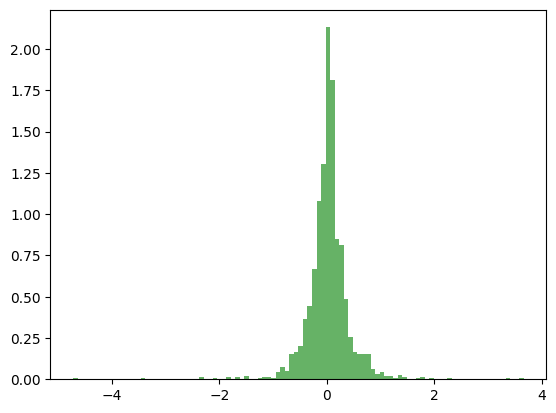

In [13]:
liste = (dB* 365.25**0.5)['AIRBUS'].tolist()
#Histogramme
plt.hist(liste, bins=100, density=True, alpha=0.6, color='g')

In [14]:
dB.corr()

,ACCOR,AIRBUS,AIRLIQUIDE,ARCELORMITTAL,AXA,BNPPARIBAS,BOUYGUES,BUREAUVERITAS,CAPGEMINI,CARREFOUR,...,SCHNEIDERELECTRIC,SOCIETEGENERALE,STELLANTIS,STMICROELECTRONICS,TELEPERFORMANCE,THALES,TOTALENERGIES,UNIBAILRODAMCOWESTFIELD,VEOLIA,VINCI
ACCOR,1.000000,0.641837,0.399993,0.507855,0.575578,0.590361,0.537767,0.419409,0.445566,0.238467,...,0.484397,0.581524,0.536584,0.417417,0.228296,0.380068,0.487393,0.506125,0.480962,0.624266
AIRBUS,0.641837,1.000000,0.446043,0.524722,0.563954,0.567477,0.575306,0.436908,0.457221,0.202498,...,0.506325,0.550878,0.547990,0.432694,0.251954,0.520712,0.513938,0.474729,0.495596,0.650801
AIRLIQUIDE,0.399993,0.446043,1.000000,0.436520,0.516126,0.450431,0.487730,0.514227,0.460378,0.311360,...,0.612315,0.415686,0.454049,0.455674,0.268595,0.338025,0.412542,0.352283,0.490115,0.561961
ARCELORMITTAL,0.507855,0.524722,0.436520,1.000000,0.580188,0.610331,0.524506,0.380445,0.432847,0.277436,...,0.529614,0.614656,0.596751,0.524420,0.248121,0.342395,0.575247,0.409252,0.410834,0.523698
AXA,0.575578,0.563954,0.516126,0.580188,1.000000,0.716839,0.599488,0.451345,0.467813,0.320397,...,0.558407,0.698708,0.588991,0.435222,0.242904,0.386720,0.606562,0.473438,0.550677,0.656077
BNPPARIBAS,0.590361,0.567477,0.450431,0.610331,0.716839,1.000000,0.589574,0.439977,0.409778,0.312397,...,0.547240,0.850433,0.611283,0.451592,0.207256,0.313044,0.589995,0.470029,0.524008,0.632632
BOUYGUES,0.537767,0.575306,0.487730,0.524506,0.599488,0.589574,1.000000,0.432983,0.405124,0.323467,...,0.504970,0.584696,0.570882,0.411110,0.246998,0.404801,0.516295,0.452056,0.501255,0.691100
BUREAUVERITAS,0.419409,0.436908,0.514227,0.380445,0.451345,0.439977,0.432983,1.000000,0.453058,0.210626,...,0.507958,0.401675,0.423542,0.406832,0.329903,0.323280,0.345249,0.357723,0.454879,0.476396
CAPGEMINI,0.445566,0.457221,0.460378,0.432847,0.467813,0.409778,0.405124,0.453058,1.000000,0.122291,...,0.527723,0.383415,0.454937,0.527252,0.305446,0.274067,0.347387,0.362553,0.460598,0.469910
CARREFOUR,0.238467,0.202498,0.311360,0.277436,0.320397,0.312397,0.323467,0.210626,0.122291,1.000000,...,0.230679,0.319308,0.287257,0.141997,0.114367,0.179129,0.279462,0.190234,0.247019,0.319292


In [15]:
dVt = realized_var - realized_var.shift(1)
dVt.dropna(inplace=True)
dVt.head(5)

,ACCOR,AIRBUS,AIRLIQUIDE,ARCELORMITTAL,AXA,BNPPARIBAS,BOUYGUES,BUREAUVERITAS,CAPGEMINI,CARREFOUR,...,SCHNEIDERELECTRIC,SOCIETEGENERALE,STELLANTIS,STMICROELECTRONICS,TELEPERFORMANCE,THALES,TOTALENERGIES,UNIBAILRODAMCOWESTFIELD,VEOLIA,VINCI
date,,,,,,,,,,,,,,,,,,,,,
2018-07-04,3.981196e-07,-3.679260e-06,-1.363395e-06,-0.000064,1.985569e-06,-0.000006,-1.130536e-06,8.488467e-06,2.447800e-05,1.557233e-05,...,7.492701e-06,4.850033e-07,-1.141292e-05,0.000013,-7.800396e-07,-3.732391e-07,-1.880282e-06,0.000009,-2.577327e-06,1.261936e-06
2018-07-05,-2.276227e-05,-4.273560e-07,1.449891e-05,0.000090,-1.755700e-06,0.000012,7.473637e-06,-2.626672e-06,4.386148e-06,1.690268e-05,...,5.544351e-07,6.515508e-06,6.092412e-05,0.000048,2.751607e-06,-1.078548e-06,2.303218e-06,-0.000003,1.121686e-05,6.664802e-06
2018-07-06,-2.428603e-06,-4.225868e-06,4.998392e-06,-0.000013,3.054215e-08,-0.000002,-7.284590e-07,-2.357299e-06,-3.350258e-07,-6.858075e-06,...,-5.597336e-07,-1.651185e-06,-5.532979e-07,0.000001,9.753941e-07,-2.024905e-05,1.935100e-06,-0.000002,2.476531e-05,-1.050224e-06
2018-07-09,1.409669e-06,-1.358957e-08,-6.108819e-07,-0.000002,-1.201100e-07,-0.000002,-2.209609e-07,-2.826678e-07,6.217236e-09,-4.151646e-08,...,1.211955e-06,-1.534820e-06,-4.467726e-09,-0.000002,7.458841e-07,-2.606712e-07,4.628167e-07,-0.000001,6.342939e-07,-3.468819e-08
2018-07-10,-8.378973e-06,6.633339e-05,2.114746e-06,-0.000002,2.586474e-06,0.000005,1.343894e-07,-8.209725e-07,-5.168844e-06,-4.887939e-05,...,7.211117e-07,9.973890e-07,1.433874e-05,0.000027,2.845653e-06,5.553367e-06,-1.007078e-06,-0.000007,4.597050e-07,-8.845685e-07


In [16]:
theta / 365.25**0.5 - realized_var.iloc[:-1,:]

,ACCOR,AIRBUS,AIRLIQUIDE,ARCELORMITTAL,AXA,BNPPARIBAS,BOUYGUES,BUREAUVERITAS,CAPGEMINI,CARREFOUR,...,SCHNEIDERELECTRIC,SOCIETEGENERALE,STELLANTIS,STMICROELECTRONICS,TELEPERFORMANCE,THALES,TOTALENERGIES,UNIBAILRODAMCOWESTFIELD,VEOLIA,VINCI
date,,,,,,,,,,,,,,,,,,,,,
2018-07-03,0.000138,0.000005,0.000169,-0.000050,0.000214,0.000196,0.000182,0.000046,0.000149,0.000114,...,0.000120,0.000203,-0.000014,-0.000236,0.000048,0.000171,0.000113,0.000193,0.000131,0.000157
2018-07-04,0.000138,0.000009,0.000171,0.000015,0.000212,0.000202,0.000183,0.000037,0.000124,0.000098,...,0.000113,0.000202,-0.000002,-0.000249,0.000049,0.000171,0.000115,0.000185,0.000134,0.000156
2018-07-05,0.000161,0.000010,0.000156,-0.000076,0.000214,0.000189,0.000176,0.000040,0.000120,0.000081,...,0.000112,0.000196,-0.000063,-0.000297,0.000046,0.000172,0.000113,0.000187,0.000123,0.000149
2018-07-06,0.000163,0.000014,0.000151,-0.000063,0.000214,0.000191,0.000177,0.000042,0.000120,0.000088,...,0.000113,0.000197,-0.000063,-0.000298,0.000045,0.000192,0.000111,0.000190,0.000098,0.000150
2018-07-09,0.000162,0.000014,0.000152,-0.000060,0.000214,0.000193,0.000177,0.000042,0.000120,0.000088,...,0.000112,0.000199,-0.000063,-0.000296,0.000045,0.000193,0.000110,0.000191,0.000097,0.000150
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-02-28,0.000074,0.000066,0.000149,-0.000858,0.000146,0.000065,0.000203,0.000060,-0.000576,-0.000236,...,-0.000168,-0.000654,-0.000177,-0.000516,-0.000446,0.000086,0.000186,0.000065,0.000129,0.000157
2025-03-03,0.000073,0.000048,0.000150,-0.000854,0.000145,0.000075,0.000203,0.000063,-0.000576,-0.000235,...,-0.000164,-0.000637,-0.000165,-0.000504,-0.000456,-0.000005,0.000187,0.000067,0.000130,0.000158
2025-03-04,0.000010,-0.000004,0.000141,-0.001028,0.000161,0.000075,0.000204,0.000065,-0.000571,-0.000241,...,-0.000282,-0.000725,-0.000709,-0.000913,-0.000472,-0.000015,0.000163,0.000072,0.000137,0.000164


In [17]:
dVt = realized_var - realized_var.shift(1)
dVt.dropna(inplace=True)
dW = (dVt - kappa/365.25*(theta/365.25**0.5 - realized_var.iloc[:-1,:]) ) * 1/np.sqrt(realized_var.iloc[:-1,:]) / sigma
dW.dropna(inplace=True)
dW.tail(5)

,ACCOR,AIRBUS,AIRLIQUIDE,ARCELORMITTAL,AXA,BNPPARIBAS,BOUYGUES,BUREAUVERITAS,CAPGEMINI,CARREFOUR,...,SCHNEIDERELECTRIC,SOCIETEGENERALE,STELLANTIS,STMICROELECTRONICS,TELEPERFORMANCE,THALES,TOTALENERGIES,UNIBAILRODAMCOWESTFIELD,VEOLIA,VINCI
date,,,,,,,,,,,,,,,,,,,,,
2025-02-28,-0.000745,-0.000483,0.000627,0.000526,0.000992,-0.000524,-0.001216,0.003548,-0.000281,-0.000928,...,-0.002509,0.002786,0.001139,0.002610,0.059277,0.004046,-0.000925,0.000601,0.000845,-0.000799
2025-03-03,0.000076,0.005594,-0.001023,0.000388,-0.000298,-0.003528,-0.001453,-0.001066,0.000858,0.000228,...,-0.000594,-0.001880,-0.002193,-0.001348,0.002319,0.026362,-0.001519,-0.000604,-0.000644,-0.001084
2025-03-04,0.018763,0.014958,0.003626,0.023408,-0.008235,-0.000435,-0.002155,-0.000880,0.000044,0.001503,...,0.024070,0.013923,0.081353,0.055995,0.003454,0.003020,0.011541,-0.002028,-0.003647,-0.004025
2025-03-05,0.006201,0.008692,0.002685,0.051618,0.001053,0.018026,0.027874,-0.002921,0.026717,0.001165,...,0.004750,0.010439,0.019820,0.014279,0.022042,0.041631,-0.007594,0.009850,0.007121,0.035396
2025-03-06,-0.002922,-0.000586,-0.003452,-0.074171,-0.002127,0.004161,0.031124,-0.000753,0.018147,0.008034,...,-0.008017,-0.140343,0.003868,0.010499,0.032494,-0.016863,-0.003420,0.020225,0.000451,-0.001963


(array([0.01788447, 0.00894223, 0.00894223, 0.        , 0.        ,
        0.        , 0.        , 0.00894223, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.00894223, 0.00894223,
        0.        , 0.        , 0.        , 0.        , 0.00894223,
        0.        , 0.01788447, 0.00894223, 0.00894223, 0.        ,
        0.        , 0.        , 0.01788447, 0.00894223, 0.        ,
        0.0268267 , 0.00894223, 0.03576893, 0.0804801 , 0.03576893,
        0.12519126, 0.0804801 , 0.07153786, 0.13413349, 0.25038252,
        0.38451601, 0.42922718, 0.76008979, 2.76314995, 6.28638969,
        1.56489075, 0.58124513, 0.42922718, 0.33086262, 0.19672912,
        0.16096019, 0.15201796, 0.04471116, 0.03576893, 0.0268267 ,
        0.0268267 , 0.00894223, 0.01788447, 0.        , 0.0268267 ,
        0.        , 0.        , 0.00894223, 0.00

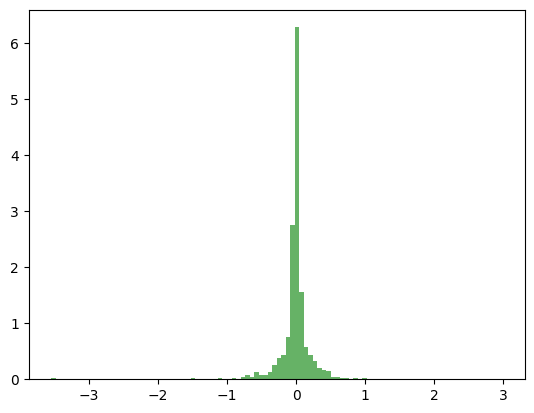

In [18]:
liste = (dW* 365.25**0.5)['AIRBUS'].tolist()
#Histogramme
plt.hist(liste, bins=100, density=True, alpha=0.6, color='g')

In [19]:
dW.corr()

,ACCOR,AIRBUS,AIRLIQUIDE,ARCELORMITTAL,AXA,BNPPARIBAS,BOUYGUES,BUREAUVERITAS,CAPGEMINI,CARREFOUR,...,SCHNEIDERELECTRIC,SOCIETEGENERALE,STELLANTIS,STMICROELECTRONICS,TELEPERFORMANCE,THALES,TOTALENERGIES,UNIBAILRODAMCOWESTFIELD,VEOLIA,VINCI
ACCOR,1.000000,0.419617,0.276101,0.281047,0.353645,0.340870,0.267159,0.290746,0.211497,0.097453,...,0.399860,0.377413,0.282172,0.190150,0.044703,0.272164,0.359185,0.318366,0.401819,0.462720
AIRBUS,0.419617,1.000000,0.250104,0.341727,0.350690,0.382072,0.305200,0.265869,0.267343,0.096160,...,0.331294,0.382487,0.306128,0.233231,0.048412,0.384050,0.434493,0.335351,0.358300,0.510192
AIRLIQUIDE,0.276101,0.250104,1.000000,0.298845,0.329114,0.281456,0.228419,0.255754,0.244310,0.148037,...,0.412199,0.265839,0.254487,0.286422,0.104309,0.172828,0.304382,0.218930,0.421108,0.379754
ARCELORMITTAL,0.281047,0.341727,0.298845,1.000000,0.410039,0.403085,0.276472,0.170032,0.267432,0.118651,...,0.392998,0.466699,0.339797,0.265149,0.054916,0.270783,0.470416,0.237429,0.360732,0.411150
AXA,0.353645,0.350690,0.329114,0.410039,1.000000,0.443960,0.316967,0.273863,0.307875,0.124553,...,0.445391,0.456062,0.347629,0.273987,0.072471,0.264885,0.496696,0.337785,0.504089,0.477389
BNPPARIBAS,0.340870,0.382072,0.281456,0.403085,0.443960,1.000000,0.214192,0.175557,0.233357,0.094956,...,0.384756,0.657096,0.310458,0.242901,0.061822,0.222037,0.437033,0.352301,0.392453,0.458876
BOUYGUES,0.267159,0.305200,0.228419,0.276472,0.316967,0.214192,1.000000,0.144289,0.207141,0.129093,...,0.276549,0.241710,0.264268,0.161514,0.046537,0.219387,0.328505,0.249989,0.326260,0.415950
BUREAUVERITAS,0.290746,0.265869,0.255754,0.170032,0.273863,0.175557,0.144289,1.000000,0.235414,0.110291,...,0.268060,0.195430,0.172902,0.205147,0.123084,0.167323,0.181362,0.221412,0.299268,0.266387
CAPGEMINI,0.211497,0.267343,0.244310,0.267432,0.307875,0.233357,0.207141,0.235414,1.000000,0.141471,...,0.344132,0.241379,0.223078,0.273261,0.155764,0.208609,0.282397,0.262584,0.285333,0.305355
CARREFOUR,0.097453,0.096160,0.148037,0.118651,0.124553,0.094956,0.129093,0.110291,0.141471,1.000000,...,0.158235,0.109165,0.115056,0.126288,0.060400,0.097839,0.148394,0.115950,0.193493,0.216663


In [20]:
# ajouter "S_" devant le nom de chaque colonne de dB
dB.columns = ['S_' + col for col in dB.columns]
# ajouter "V_" devant le nom de chaque colonne de dW
dW.columns = ['V_' + col for col in dW.columns]
# Concaténer les deux DataFrames
dB_dW = pd.concat([dB, dW], axis=1)
dB_dW.dropna(inplace=True)
dB_dW


,S_ACCOR,S_AIRBUS,S_AIRLIQUIDE,S_ARCELORMITTAL,S_AXA,S_BNPPARIBAS,S_BOUYGUES,S_BUREAUVERITAS,S_CAPGEMINI,S_CARREFOUR,...,V_SCHNEIDERELECTRIC,V_SOCIETEGENERALE,V_STELLANTIS,V_STMICROELECTRONICS,V_TELEPERFORMANCE,V_THALES,V_TOTALENERGIES,V_UNIBAILRODAMCOWESTFIELD,V_VEOLIA,V_VINCI
date,,,,,,,,,,,,,,,,,,,,,
2018-07-04,-0.005100,0.003270,-0.008904,-0.008217,0.006033,0.000725,0.006873,-0.007893,-0.021121,0.020378,...,0.002602,-0.000865,-0.003315,0.003012,-0.000391,-0.000971,-0.001145,0.004170,-0.001613,-0.000029
2018-07-05,0.003789,-0.001839,0.016823,0.039754,0.005992,0.017724,0.010313,0.000763,0.014825,0.017852,...,-0.000158,0.003172,0.016014,0.009904,0.000766,-0.001362,0.000536,-0.002506,0.004212,0.002524
2018-07-06,0.011017,0.008555,0.010631,0.010207,0.000532,-0.004795,0.007845,0.008579,0.002800,0.004515,...,-0.000604,-0.002212,-0.000006,0.000706,0.000191,-0.013821,0.000393,-0.002485,0.009033,-0.001092
2018-07-09,0.006334,0.003842,0.000970,0.004900,0.002809,0.000693,0.000966,0.001760,0.001914,0.000667,...,0.000105,-0.002179,0.000137,0.000193,0.000119,-0.001200,-0.000186,-0.001813,-0.000072,-0.000615
2018-07-10,0.001376,0.039791,0.010979,-0.002766,-0.008421,-0.008917,0.005688,0.005467,0.008014,-0.007451,...,-0.000087,-0.000456,0.003822,0.005763,0.000800,0.002388,-0.000771,-0.005519,-0.000136,-0.001023
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-02-28,0.000073,0.004099,0.012367,0.001406,-0.006656,0.004151,0.000044,-0.015715,-0.007817,0.001950,...,-0.002509,0.002786,0.001139,0.002610,0.059277,0.004046,-0.000925,0.000601,0.000845,-0.000799
2025-03-03,0.004560,0.017767,0.006243,0.017891,0.006793,0.005960,0.002156,0.002555,-0.000603,-0.005537,...,-0.000594,-0.001880,-0.002193,-0.001348,0.002319,0.026362,-0.001519,-0.000604,-0.000644,-0.001084
2025-03-04,-0.036694,-0.032038,-0.009638,-0.051221,-0.004504,-0.031290,0.009031,-0.004105,-0.032449,0.010690,...,0.024070,0.013923,0.081353,0.055995,0.003454,0.003020,0.011541,-0.002028,-0.003647,-0.004025


In [21]:
dB_dW.corr()

,S_ACCOR,S_AIRBUS,S_AIRLIQUIDE,S_ARCELORMITTAL,S_AXA,S_BNPPARIBAS,S_BOUYGUES,S_BUREAUVERITAS,S_CAPGEMINI,S_CARREFOUR,...,V_SCHNEIDERELECTRIC,V_SOCIETEGENERALE,V_STELLANTIS,V_STMICROELECTRONICS,V_TELEPERFORMANCE,V_THALES,V_TOTALENERGIES,V_UNIBAILRODAMCOWESTFIELD,V_VEOLIA,V_VINCI
S_ACCOR,1.000000,0.641848,0.399925,0.508099,0.575705,0.590307,0.537719,0.419273,0.445480,0.238339,...,-0.060576,-0.032220,-0.034399,-0.050686,-0.014183,-0.000669,-0.072950,0.013030,-0.028686,-0.055652
S_AIRBUS,0.641848,1.000000,0.446101,0.524373,0.564207,0.567422,0.575021,0.437303,0.456858,0.202498,...,-0.099869,-0.100146,-0.073518,-0.077225,-0.024433,-0.017336,-0.130367,0.006813,-0.091875,-0.130906
S_AIRLIQUIDE,0.399925,0.446101,1.000000,0.437017,0.516136,0.450403,0.488052,0.514249,0.460495,0.311304,...,-0.061781,-0.067741,-0.048963,-0.051409,-0.005651,-0.004386,-0.078622,-0.003822,-0.085672,-0.064499
S_ARCELORMITTAL,0.508099,0.524373,0.437017,1.000000,0.581233,0.610697,0.523477,0.381546,0.432102,0.277755,...,-0.095100,-0.060165,-0.031440,-0.024017,-0.020606,0.015025,-0.065075,-0.016474,-0.087256,-0.101242
S_AXA,0.575705,0.564207,0.516136,0.581233,1.000000,0.716923,0.600294,0.451407,0.468136,0.320393,...,-0.029459,-0.060210,-0.057005,0.009075,0.007023,-0.030414,-0.053331,-0.020076,-0.101466,-0.109464
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
V_THALES,-0.000669,-0.017336,-0.004386,0.015025,-0.030414,-0.023604,-0.019260,-0.008343,0.027065,-0.015858,...,0.192224,0.253782,0.218983,0.168160,0.051730,1.000000,0.309967,0.254655,0.238923,0.328085
V_TOTALENERGIES,-0.072950,-0.130367,-0.078622,-0.065075,-0.053331,-0.087312,-0.104539,-0.083078,-0.035354,-0.038960,...,0.409226,0.441700,0.333431,0.263337,0.057900,0.309967,1.000000,0.300068,0.385554,0.510851
V_UNIBAILRODAMCOWESTFIELD,0.013030,0.006813,-0.003822,-0.016474,-0.020076,-0.013676,-0.034268,-0.028066,-0.020163,-0.044993,...,0.248282,0.313770,0.261135,0.235223,0.128365,0.254655,0.300068,1.000000,0.368842,0.396968
V_VEOLIA,-0.028686,-0.091875,-0.085672,-0.087256,-0.101466,-0.099654,-0.143940,-0.033340,-0.069335,-0.075753,...,0.450490,0.444049,0.330818,0.249574,0.087611,0.238923,0.385554,0.368842,1.000000,0.576169
